In [2]:
%cd ~/Desktop/working-directory/UQ_Python
    
%load_ext autoreload

import scipy as sp
import numpy as np
from sklearn.datasets import make_moons
from datasets.Graph_manager import Graph_manager
import matplotlib.pyplot as plt
import random

/home/hao/Desktop/working-directory/UQ_Python
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
%autoreload 2

In [354]:
N = 2000
gamma2 = 0.00001
alpha  = 1.0
tau    = 0.1

X, labels = make_moons(N, noise=0.2)
X = np.vstack(( X[labels == 1, :], X[labels == 0, :]))
labels = np.vstack((labels[labels == 1, np.newaxis], labels[labels == 0, np.newaxis]))
labels2 = 2 * labels - 1    

Compute eigs from scratch


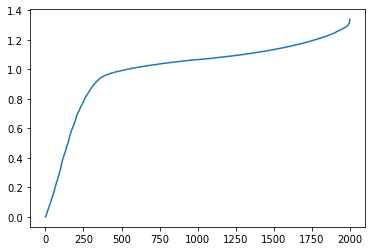

In [368]:
gm = Graph_manager()
graph_params = {
    'knn'    : 15,
    'sigma'  : 1,
    'Ltype'  : 'normed',
    'n_eigs' : N,
    'zp_k'   : None,
}

w, v = gm.from_features(X, graph_params, debug=True)
plt.plot(w)
d = (tau ** (2. * alpha)) * ((w + tau**2.) ** (-alpha))

C = v @ sp.sparse.diags(d, format='csr') @ v.T
C_inv = v @ sp.sparse.diags(1./d, format='csr') @ v.T

In [372]:
def v_risk(C_inv, labeled, gamma2):
    """
    calculate the risk of each unlabeled point
    """
    N = C_inv.shape[0]
    unlabeled = list(filter(lambda x: x not in labeled, range(N)))
    B_diag = [1 if i in labeled else 0 for i in range(N)]
    B = sp.sparse.diags(B_diag, format='csr')
    C = sp.linalg.inv(C_inv + B/gamma2)
    return np.sum(C.diagonal()[unlabeled]), C

def V_opt(C, unlabeled, gamma2):
    ips = np.array([np.inner(C[k,:], C[k,:]) for k in unlabeled]).flatten()
    v_opt = ips/(gamma2 + np.diag(C)[unlabeled])
    """
    v_opt = (v_opt - min(v_opt))/(max(v_opt) - min(v_opt))
    colors = [(x, 0.5,(1-x)) for x in v_opt]
    plt.scatter(X[unlabeled, 0],X[unlabeled,1], c=colors)
    plt.show()
    """
    
    k_max = unlabeled[np.argmax(v_opt)]
    return k_max

def Sigma_opt(C, unlabeled, gamma2):
    sums = np.sum(C[np.ix_(unlabeled,unlabeled)], axis=1)
    sums = np.asarray(sums).flatten()**2.
    s_opt = sums/(gamma2 + np.diag(C)[unlabeled])
    k_max = unlabeled[np.argmax(s_opt)]
    return k_max
    
#labeled = [np.argmax(C.diagonal())]
initial = random.sample(range(N), 50)
labeled = initial.copy()

unlabeled = list(filter(lambda x: x not in labeled, range(N)))
B_diag = [1 if i in labeled else 0 for i in range(N)]
B = sp.sparse.diags(B_diag, format='csr')
C = sp.linalg.inv(C_inv + B/gamma2)
# C = posterior covariance with one labeled point
 
for i in range(40):
    unlabeled = list(filter(lambda x: x not in labeled, range(N)))
    k = V_opt(C, unlabeled, gamma2)
    labeled += [k]
    ck = C[k,:]
    ckk = ck[k]
    C -= (1./(gamma2 + ckk)) * np.outer(ck,ck)

unlabeled = list(filter(lambda x: x not in labeled, range(N)))

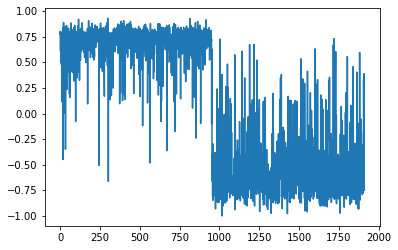

0.956020942408377


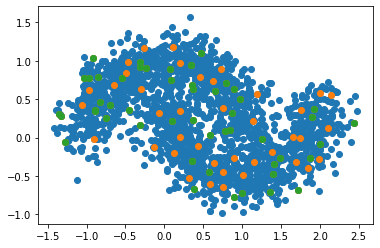

In [373]:
u = np.zeros( (N, 1) )
u[labeled, :] = labels2[labeled, :] 

B_diag = [1 if i in labeled else 0 for i in range(N)]
B = sp.sparse.diags(B_diag, format='csr')
C2 = sp.linalg.inv(C_inv + B/gamma2)


m =(np.dot(C, u))/gamma2
plt.plot(m[unlabeled])
plt.show()
print( np.sum((m[unlabeled] >= 0) == labels[unlabeled])/ (2000 - len(labeled)))

plt.scatter(X[:, 0],X[:, 1])
plt.scatter(X[labeled, 0], X[labeled, 1])
plt.scatter(X[initial, 0], X[initial, 1])

In [309]:
print(labels2)

[[ 1]
 [ 1]
 [ 1]
 ...
 [-1]
 [-1]
 [-1]]
